In [1]:
import os
import joblib # Para guardar el cerebro de tu modelo
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Configuración
RATA_TRAIN = 'Data/training_set'
RATA_TEST = 'Data/test_set'
IMG_SIZE = (64, 64) # Tamaño fijo
MODELO_FILENAME = 'modelo_svm_mascotas.pkl'


In [2]:
def extraer_caracteristicas(imagen):
    # 1. Redimensionar
    img_resized = resize(imagen, IMG_SIZE)
    # 2. HOG (Devuelve solo el vector de características)
    fd = hog(img_resized, orientations=9, pixels_per_cell=(8, 8),
             cells_per_block=(2, 2), channel_axis=-1)
    return fd

def cargar_dataset(ruta_base):
    features = []
    labels = []
    # 0: Gato, 1: Perro
    for etiqueta, carpeta in enumerate(['cats', 'dogs']):
        path = os.path.join(ruta_base, carpeta)
        images = os.listdir(path)
        print(f"Cargando {carpeta} de {ruta_base} ({len(images)} imgs)...")
        
        for img_name in images:
            if img_name.endswith('.jpg'):
                try:
                    img_path = os.path.join(path, img_name)
                    img = imread(img_path)
                    fd = extraer_caracteristicas(img)
                    features.append(fd)
                    labels.append(etiqueta)
                except:
                    pass
    return np.array(features), np.array(labels)


In [3]:
# 1. Cargar datos
print("--- Preparando datos ---")
X_train, y_train = cargar_dataset(RATA_TRAIN)

# 2. Entrenar
print("\n--- Entrenando SVM ---")
svm = SVC(kernel='linear', probability=True) # probability=True para ver % de confianza
svm.fit(X_train, y_train)

# 3. Guardar el modelo
joblib.dump(svm, MODELO_FILENAME)
print(f"\n¡Modelo guardado exitosamente como '{MODELO_FILENAME}'!")


--- Preparando datos ---
Cargando cats de Data/training_set (4001 imgs)...
Cargando dogs de Data/training_set (4006 imgs)...

--- Entrenando SVM ---

¡Modelo guardado exitosamente como 'modelo_svm_mascotas.pkl'!


Modelo cargado y listo para predecir.


c:\Users\hiurt\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128054 (\N{DOG FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


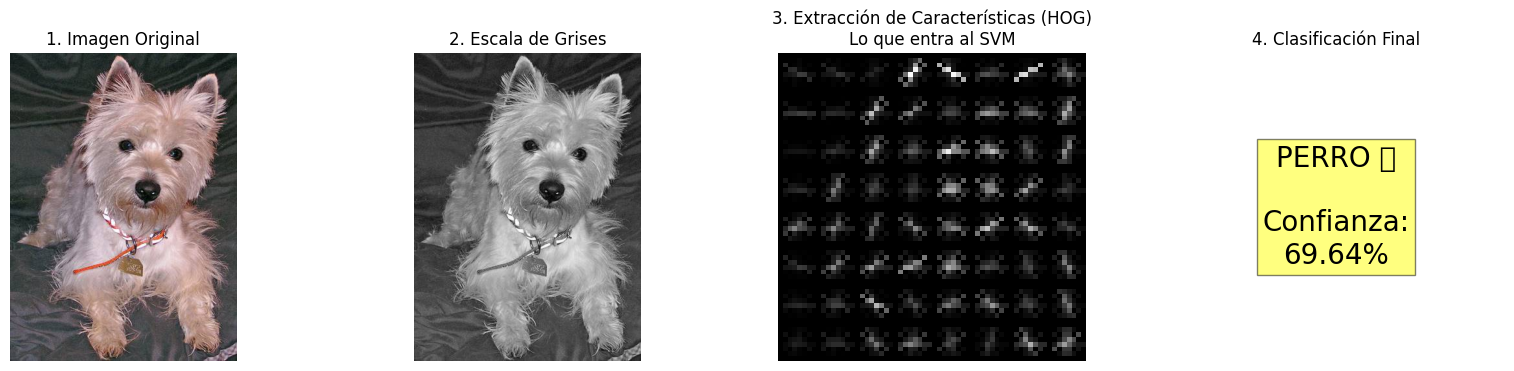

In [ ]:
# Cargar el modelo entrenado (carga instantánea)
modelo_cargado = joblib.load(MODELO_FILENAME)
print("Modelo cargado y listo para predecir.")

def analizar_imagen(ruta_imagen):
    # A. Cargar imagen original
    img_orig = imread(ruta_imagen)
    
    # Crear una figura para mostrar los pasos
    fig, axes = plt.subplots(1, 4, figsize=(20, 4))
    
    # PASO 1: Original
    axes[0].imshow(img_orig)
    axes[0].set_title("1. Imagen Original")
    axes[0].axis('off')
    
    # PASO 2: Escala de Grises (Pre-procesamiento visual)
    from skimage.color import rgb2gray
    img_gray = rgb2gray(img_orig)
    axes[1].imshow(img_gray, cmap='gray')
    axes[1].set_title("2. Escala de Grises")
    axes[1].axis('off')
    
    # PASO 3: Lo que "ve" la máquina (HOG)
    img_resized = resize(img_orig, IMG_SIZE)
    fd, hog_image = hog(img_resized, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), visualize=True, channel_axis=-1)
    
    # Mejorar contraste del HOG para visualización humana
    from skimage import exposure
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    
    axes[2].imshow(hog_image_rescaled, cmap='gray')
    axes[2].set_title("3. Extracción de Características (HOG)\nLo que entra al SVM")
    axes[2].axis('off')
    
    # PASO 4: Clasificación
    # Usamos el modelo cargado para predecir sobre el vector 'fd'
    prediccion = modelo_cargado.predict([fd])[0]
    probs = modelo_cargado.predict_proba([fd])[0] # Probabilidades
    
    clase = "PERRO" if prediccion == 1 else "GATO"
    confianza = probs[prediccion] * 100
    
    # Mostrar resultado
    axes[3].text(0.5, 0.5, f"{clase}\n\nConfianza:\n{confianza:.2f}%", 
                 horizontalalignment='center', verticalalignment='center', fontsize=20,
                 bbox=dict(facecolor='green' if confianza > 70 else 'yellow', alpha=0.5))
    axes[3].set_title("4. Clasificación Final")
    axes[3].axis('off')
    
    plt.show()

# --- ¡PRUEBA TU DEMO AQUÍ! ---
# Cambia esta ruta por cualquier imagen de internet o de tu carpeta de test
analizar_imagen('Data/test_set/dogs/dog.4156.jpg') 
